## the content 

Our first task is to load the content and style images. Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

In [52]:
%matplotlib inline
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from __future__ import print_function
import matplotlib.pyplot as plt

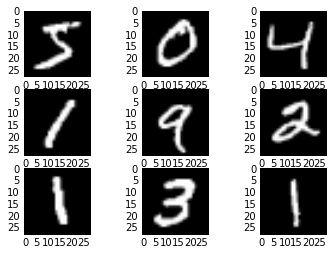

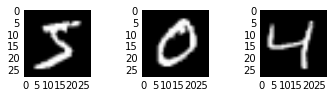

In [70]:
# get MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

plt.subplot(331)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(332)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(333)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [54]:
# reshape
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# rescale
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [55]:
# one-hot encode the y integer vectors into binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [56]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

As is clear from the table above, the model we're working with has a lot of layers. Keras has its own names for these layers. Let's make a list of these names so that we can easily refer to individual layers later.

In [59]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=15,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 16s - loss: 0.2461 - acc: 0.9232 - val_loss: 0.1112 - val_acc: 0.9663
Epoch 2/15
60000/60000 [==============================] - 16s - loss: 0.1029 - acc: 0.9686 - val_loss: 0.0831 - val_acc: 0.9752
Epoch 3/15
60000/60000 [==============================] - 17s - loss: 0.0753 - acc: 0.9769 - val_loss: 0.0836 - val_acc: 0.9771
Epoch 4/15
60000/60000 [==============================] - 17s - loss: 0.0589 - acc: 0.9824 - val_loss: 0.0850 - val_acc: 0.9776
Epoch 5/15
60000/60000 [==============================] - 16s - loss: 0.0481 - acc: 0.9854 - val_loss: 0.0791 - val_acc: 0.9809
Epoch 6/15
60000/60000 [==============================] - 17s - loss: 0.0437 - acc: 0.9872 - val_loss: 0.0861 - val_acc: 0.9794
Epoch 7/15
60000/60000 [==============================] - 17s - loss: 0.0374 - acc: 0.9887 - val_loss: 0.0831 - val_acc: 0.9817
Epoch 8/15
60000/60000 [==============================

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


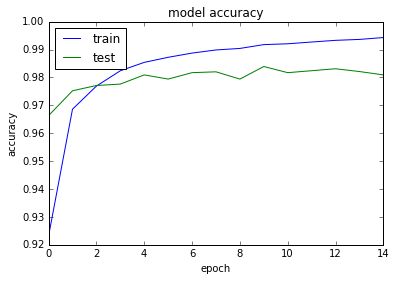

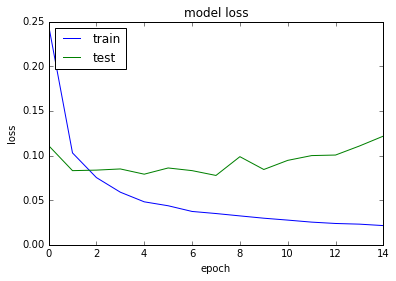

In [60]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.121741154847
Test accuracy: 0.9809


We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [62]:
classes = model.predict_classes(x_test, batch_size=1)
print(classes)

 9992/10000 [============================>.] - ETA: 0s[7 2 1 ..., 4 5 6]


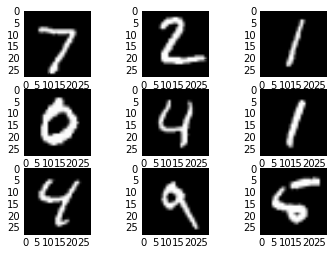

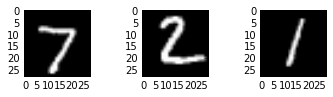

In [71]:
# create a grid of 3x3 images
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

plt.subplot(331)
plt.imshow(x_test[0], cmap=plt.get_cmap('gray'))
plt.subplot(332)
plt.imshow(x_test[1], cmap=plt.get_cmap('gray'))
plt.subplot(333)
plt.imshow(x_test[2], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()